In [1]:
!pip install -U -q keras-nlp
!pip install --upgrade keras
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-ker

In [2]:
import os
from google.colab import userdata
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [3]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [5]:
%%capture

import kagglehub

# Download latest version
path = kagglehub.model_download("keras/paligemma2/keras/pali_gemma2_pt_3b_224")

In [6]:
print("Path to model files:", path)

Path to model files: /root/.cache/kagglehub/models/keras/paligemma2/keras/pali_gemma2_pt_3b_224/1


In [7]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3
!pip install einops

In [8]:
!pip install -q -U keras keras-hub

import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

BATCH_SIZE = 1
TRAIN_EXAMPLES = 4
LEARNING_RATE = 0.003

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

In [9]:
import io
import json
import os
import urllib

import base64
import html

import numpy as np
import keras
import keras_hub
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from PIL import Image

train_file = urllib.request.urlopen(
    "https://storage.googleapis.com/longcap100/data_train90.jsonl"
)
val_file = urllib.request.urlopen(
    "https://storage.googleapis.com/longcap100/data_val10.jsonl"
)

target_size = (224, 224)

def load_image(image_url):
    image = tf.io.decode_jpeg(urllib.request.urlopen(image_url).read())
    return tf.image.resize(image, size=target_size)

def load_dataset(file):
    captions = []
    images = []
    for line in file:
        sample = json.loads(line)
        captions.append(sample["suffix"])
        image_name = sample["image"]
        image_url = f"https://storage.googleapis.com/longcap100/{image_name}"
        images.append(load_image(image_url))
    return tf.data.Dataset.from_tensor_slices({
        "images": images,
        "prompts": ["caption en\n"] * len(images),
        "responses": captions,
    })

train_data = load_dataset(train_file).shuffle(1000).batch(BATCH_SIZE)
val_data = load_dataset(val_file).shuffle(1000).batch(BATCH_SIZE)

Training examples



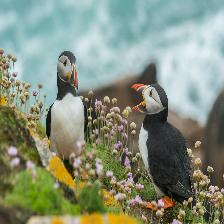
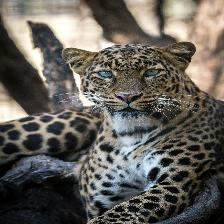
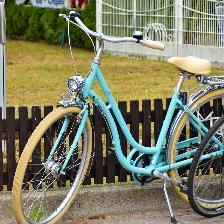
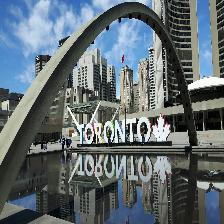
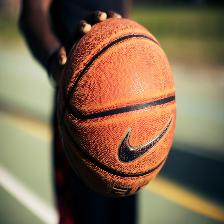
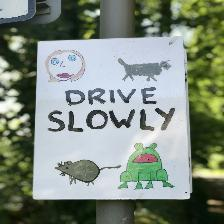
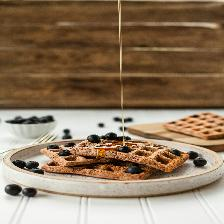
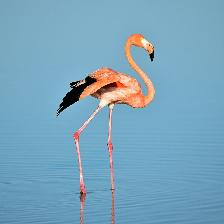

In [11]:
def render_inline(image, resize=(224, 224)):
  """Convert image into inline html."""
  image = tf.keras.preprocessing.image.array_to_img(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = np.asarray(image)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""

for element in train_data.take(8):
  caption = tf.compat.as_str_any(element["responses"].numpy()[0])
  html_out += render_example(element["images"].numpy()[0], caption)

print("Training examples")
display(HTML(html_out))

In [12]:
pali_gemma_lm = keras_hub.models.PaliGemmaCausalLM.from_preset(
    "/root/.cache/kagglehub/models/keras/paligemma2/keras/pali_gemma2_pt_3b_224/1"
)
pali_gemma_lm.summary()

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,094,960 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,094,960 (11.30 GB)

 Trainable params: 3,032,094,960 (11.30 GB)

 Non-trainable params: 0 (0.00 B)


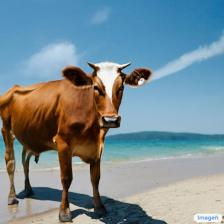


Inference Result



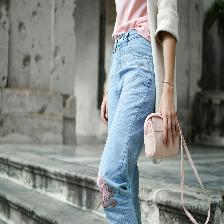
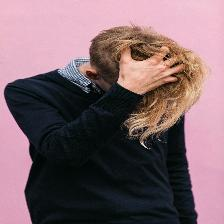
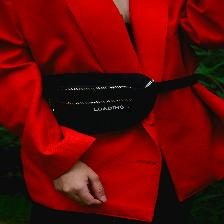
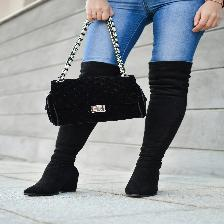

In [13]:
test_image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
test_image = load_image(test_image_url)

def inference_test(image):
  prompt = 'caption en\n'
  output = pali_gemma_lm.generate(
      inputs={
          "images": image,
          "prompts": prompt,
      }
  )
  return render_example(image, output)

display(HTML(inference_test(test_image)))


def make_predictions():
  html_out = ""
  for element in val_data.take(4):
    html_out += inference_test(element["images"].numpy()[0])

  print("\nInference Result")
  display(HTML(html_out))

make_predictions()

In [14]:
pali_gemma_lm.backbone.enable_lora(4)
pali_gemma_lm.summary()

pali_gemma_lm.preprocessor.sequence_length = 64

def plot_scheduler(step, scheduler):
  x = range(step)
  y = []
  for step in x:
    y.append(scheduler(step))
  plt.plot(x, y, label=scheduler.name)
  plt.xlabel('Epoch')
  plt.ylabel('Learning Rate')
  plt.legend()
  plt.show()

optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

pali_gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,035,023,600 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,035,023,600 (11.31 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 3,032,094,960 (11.30 GB)

Epoch 1/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 362ms/step - loss: 1.7565 - sparse_categorical_accuracy: 0.5326
Epoch 2/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - loss: 0.9555 - sparse_categorical_accuracy: 0.6919
Epoch 3/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.7626
Epoch 4/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.6596 - sparse_categorical_accuracy: 0.7773


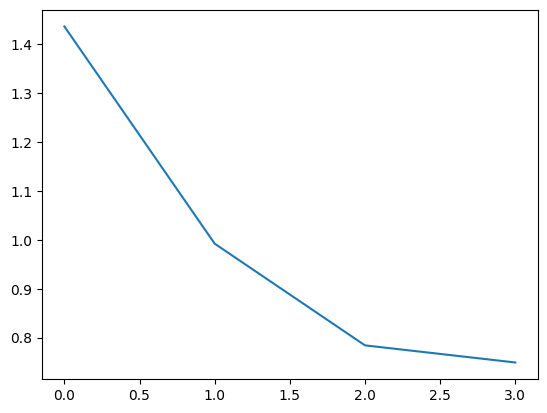

In [15]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if(epoch % EVAL_STEPS == EVAL_STEPS-1):
          display(HTML(inference_test(test_image)))
          make_predictions()

history = pali_gemma_lm.fit(train_data, epochs=TRAIN_STEPS)
plt.plot(history.history['loss'])
plt.show()


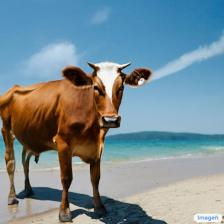


Inference Result



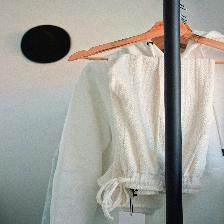
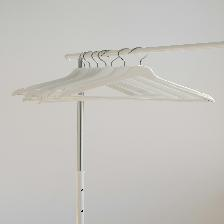
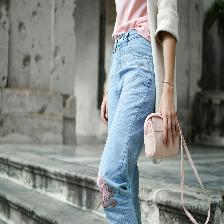
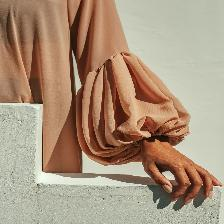

In [16]:
display(HTML(inference_test(test_image)))
make_predictions()